# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

Accorrding to the paper, The dataset collected is related to 17 phone campaigns that occurred between May 2008 and Nov. 2010.

For each contact, a large number of attributes was stored.

The success rate of attracting long term deposits was around 8%.

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import time  

from scipy.stats import chi2_contingency
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn import metrics
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

In [29]:
df = pd.read_csv('bank-additional-full.csv', sep = ';')

In [30]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



In [32]:
#Let us check for NaNs
nan_counts = df.isna().sum()
print(nan_counts)

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64


## Observation:
There are no "NaN" values, which is good.
Now let us see al of the possible values that the categorical variables take.

# Analysis of Categorical Variables and their impact on "y"

In [33]:
# Identify categorical columns
categorical_columns = df.select_dtypes(include=['category', 'object']).columns

In [34]:
# Function to format text as bold
def make_bold(text):
    return f"\033[1m{text}\033[0m"

# Print unique values for each categorical column with bold column names
for column in categorical_columns:
    unique_values = df[column].unique()
    formatted_column = make_bold(f"{column}:")
    print(formatted_column)
    for value in unique_values:
        print(value)
    print()


job:
housemaid
services
admin.
blue-collar
technician
retired
management
unemployed
self-employed
unknown
entrepreneur
student

marital:
married
single
divorced
unknown

education:
basic.4y
high.school
basic.6y
basic.9y
professional.course
unknown
university.degree
illiterate

default:
no
unknown
yes

housing:
no
yes
unknown

loan:
no
yes
unknown

contact:
telephone
cellular

month:
may
jun
jul
aug
oct
nov
dec
mar
apr
sep

day_of_week:
mon
tue
wed
thu
fri

poutcome:
nonexistent
failure
success

y:
no
yes



## Observation:
- Many columns contain values labled as "unkown"
- Infortunately, in real life scenarios of marketing campaigns, "uknown" is a very common value.
- Therefore, I beleive that the way to deal with it would be to treat the "uknown" values as potentially useful information--instead of imputing the values or deleting the columns that contain "uknown" values.

Next, let us see how common each value is for the categorical columns

## Let us now see a graphic representation of the values of the cathegorical columns

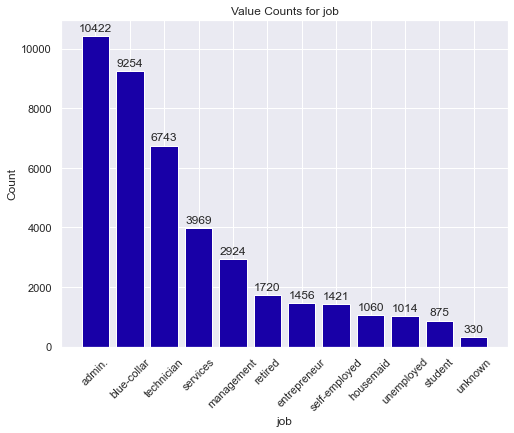

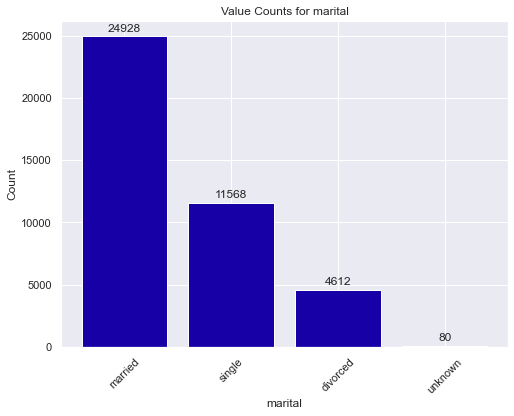

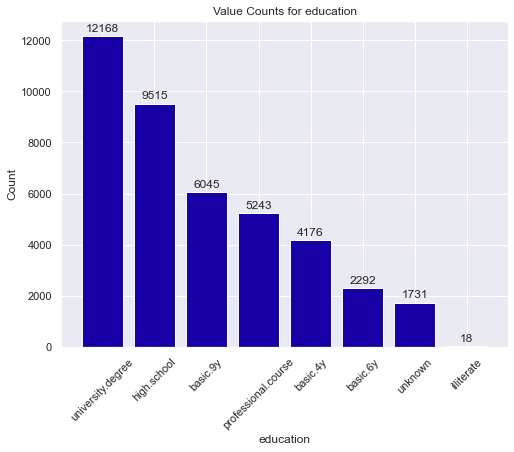

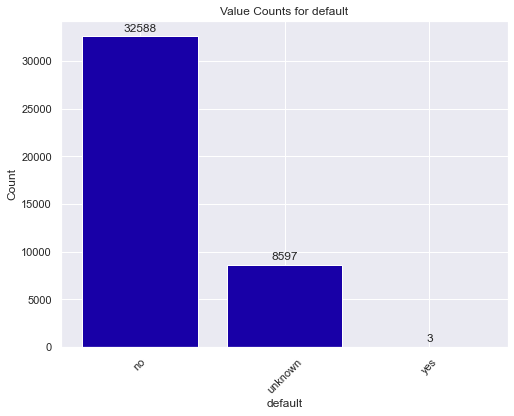

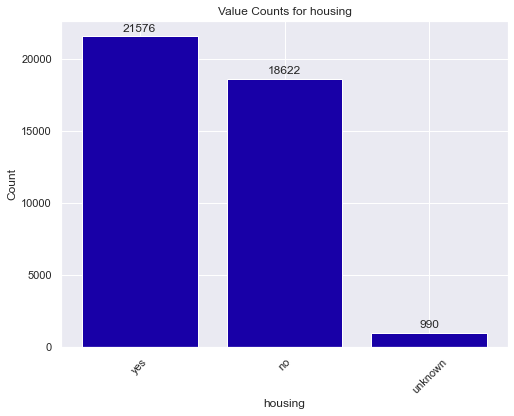

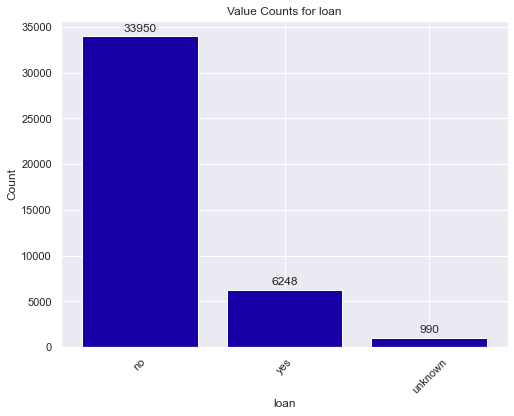

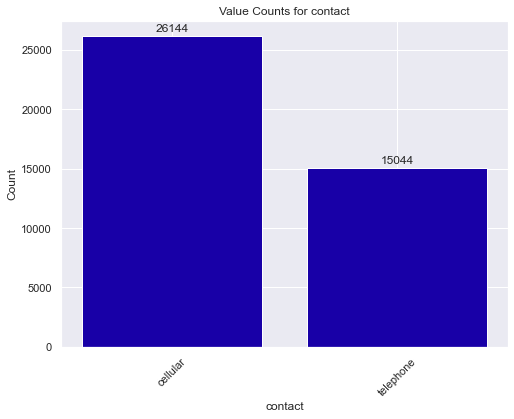

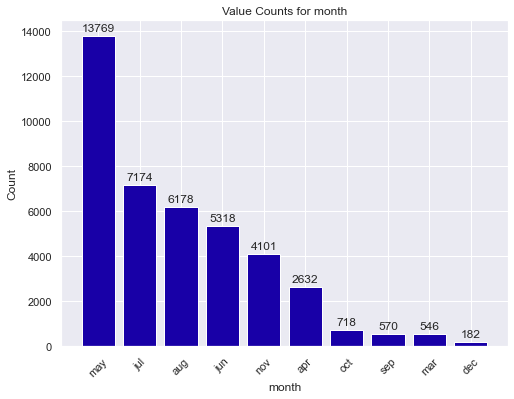

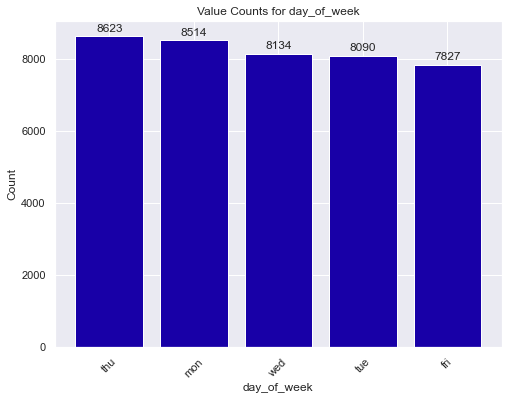

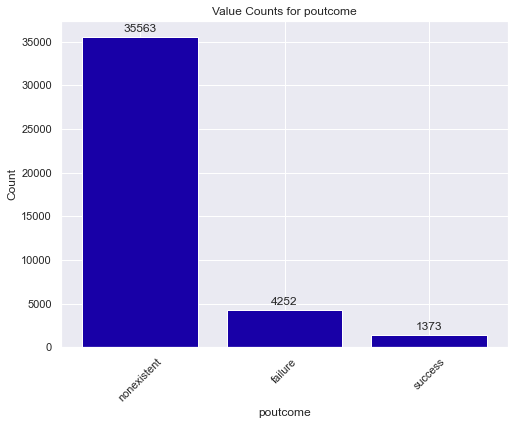

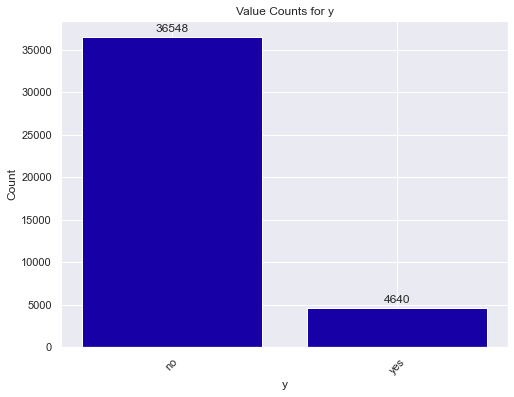

In [35]:
# Create bar charts for each categorical column with annotations
for column in categorical_columns:
    # Get value counts
    value_counts = df[column].value_counts()

    # Create a bar chart
    plt.figure(figsize=(8, 6))
    bars = plt.bar(value_counts.index, value_counts.values)
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.title(f'Value Counts for {column}')
    plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility

    # Annotate each bar with counts
    for bar in bars:
        height = bar.get_height()
        plt.annotate(f'{int(height)}', xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3),  # Offset the text above the bar
                     textcoords='offset points',
                     ha='center', va='bottom')

    plt.show()

### Observations:
- Some of the categorical variables contain values with very low counts. We should Delete or Inpute them. For example:
- default = "yes": delete these (there are only 3 of them)
- education = "illiterate": delete these records (only 18 records)
- marital = uknown: delete these records (only 80 records)

by doing so, we will eliminate the 3 one-hot encoded columns without loosing much useful information.

We should decide what to do with these records:
- Housing: impute "uknown" - 990 records
- Loan: impute "uknonw" 990 records (are they the same by any chance)?
    

In [36]:
# Let us drop the 3 records where "default" = "yes"
df = df[df['default'] != 'yes']

In [37]:
# Leet us drop the 18 records where education = "illiterate"
df = df[df['education'] != 'illiterate']

In [38]:
# Leet us drop the 80 records where marital = "unknown"
df = df[df['marital'] != 'unknown']

In [39]:
#Let us see the sample of records where "housing" is "uknown"
sample_df = df[df['housing'] == 'unknown'].sample(n=10) 
sample_df

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
29134,39,management,married,university.degree,no,unknown,unknown,cellular,apr,fri,...,1,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1,no
38732,45,admin.,single,university.degree,no,unknown,unknown,cellular,nov,tue,...,3,999,1,failure,-3.4,92.649,-30.1,0.715,5017.5,no
3983,52,management,divorced,high.school,no,unknown,unknown,telephone,may,mon,...,3,999,0,nonexistent,1.1,93.994,-36.4,4.858,5191.0,no
30569,39,admin.,married,high.school,no,unknown,unknown,cellular,may,mon,...,2,999,2,failure,-1.8,92.893,-46.2,1.354,5099.1,no
9083,30,services,married,high.school,unknown,unknown,unknown,telephone,jun,fri,...,1,999,0,nonexistent,1.4,94.465,-41.8,4.967,5228.1,no
35088,33,services,married,high.school,no,unknown,unknown,cellular,may,fri,...,1,999,1,failure,-1.8,92.893,-46.2,1.250,5099.1,no
5777,51,retired,married,basic.9y,no,unknown,unknown,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
29,55,unknown,married,university.degree,unknown,unknown,unknown,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
11345,47,services,single,basic.9y,no,unknown,unknown,telephone,jun,thu,...,3,999,0,nonexistent,1.4,94.465,-41.8,4.961,5228.1,yes
24114,50,admin.,single,basic.9y,no,unknown,unknown,telephone,nov,thu,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.245,5195.8,no


### Observations: 
in our sample of 10, both the "housing" and "loan" are "unkown". Let us see if this is a coincidence by counting how many records have both "uknown"

In [40]:
# Count the records where both "housing" and "loan" columns are "unknown"
count_unknown_housing_and_loan = len(df.query("housing == 'unknown' and loan == 'unknown'"))

# Print the count
print("Count of records where both 'housing' and 'loan' are 'unknown':", count_unknown_housing_and_loan)

Count of records where both 'housing' and 'loan' are 'unknown': 989


### Observation: 
It appears that out of 990 records where Housing is Uknown and out of 990 records where Loan is Uknown all but one are the same records.

Thus, we can't say that these values are missing at random (or ar uknown at random). Perhaps we should keep those records as is. 

## Let us see how each Categorical Feature impacts "y"

In [41]:
#A function to rended Stacked plot for Categorical variables in relation to "y"

def stacked_plot(x):
    sns.set(palette='nipy_spectral')
    
    #print header    
    header = make_bold(f'Breakdown for column "{column}" ')
    print(header)
    
    # Calculate and print the cross-tabulation (as numbers)
    tab1 = pd.crosstab(x, df['y'], margins=True)
    print(tab1)
    print('-' * 120)
    
    # Calculate the normalized cross-tabulation
    tab = pd.crosstab(x, df['y'], normalize='index')

    # Create a stacked bar chart
    tab.plot(kind='bar', stacked=True, figsize=(10,5))
    
    plt.legend(loc='lower left', frameon=False)
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    
    # Dynamically populate the column name into the title
    plt.title(f'Stacked Bar Chart for Column "{x.name}" ')
    
    plt.show()
    print('=' * 120)
    print('=' * 120)

In [42]:
# Identify categorical columns, excluding 'y'
cat_features = [col for col in df.select_dtypes(include=['category', 'object']).columns if col != 'y']

Breakdown for column "job" 
y                 no   yes    All
job                              
admin.          9057  1350  10407
blue-collar     8597   635   9232
entrepreneur    1329   122   1451
housemaid        950   106   1056
management      2593   328   2921
retired         1281   431   1712
self-employed   1265   148   1413
services        3640   323   3963
student          599   275    874
technician      6001   728   6729
unemployed       864   144   1008
unknown          287    34    321
All            36463  4624  41087
------------------------------------------------------------------------------------------------------------------------


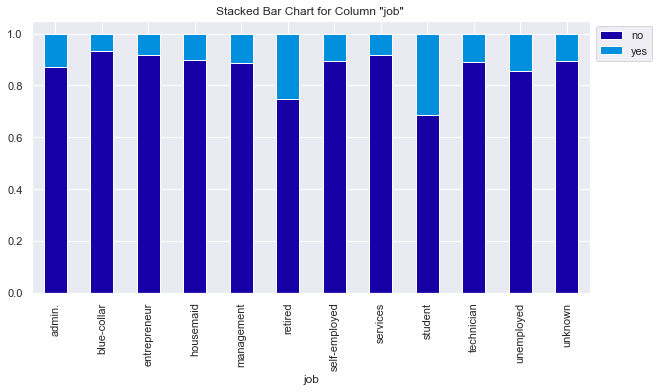

Breakdown for column "marital" 
y            no   yes    All
marital                     
divorced   4135   475   4610
married   22381  2529  24910
single     9947  1620  11567
All       36463  4624  41087
------------------------------------------------------------------------------------------------------------------------


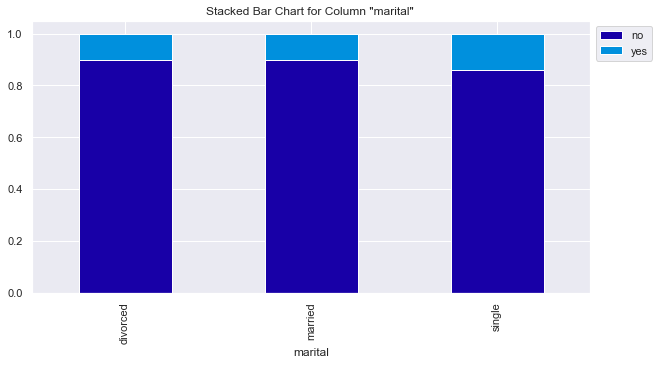

Breakdown for column "education" 
y                       no   yes    All
education                              
basic.4y              3743   427   4170
basic.6y              2098   188   2286
basic.9y              5566   471   6037
high.school           8470  1030   9500
professional.course   4640   595   5235
university.degree    10473  1664  12137
unknown               1473   249   1722
All                  36463  4624  41087
------------------------------------------------------------------------------------------------------------------------


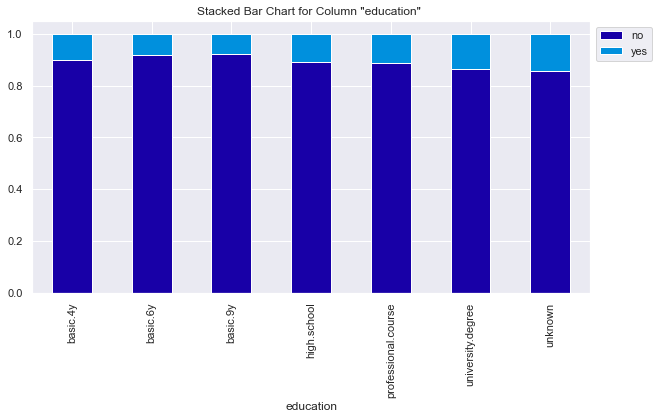

Breakdown for column "default" 
y           no   yes    All
default                    
no       28326  4182  32508
unknown   8137   442   8579
All      36463  4624  41087
------------------------------------------------------------------------------------------------------------------------


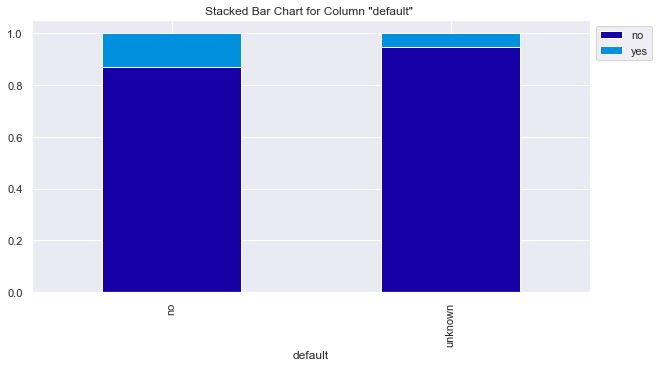

Breakdown for column "housing" 
y           no   yes    All
housing                    
no       16550  2018  18568
unknown    882   107    989
yes      19031  2499  21530
All      36463  4624  41087
------------------------------------------------------------------------------------------------------------------------


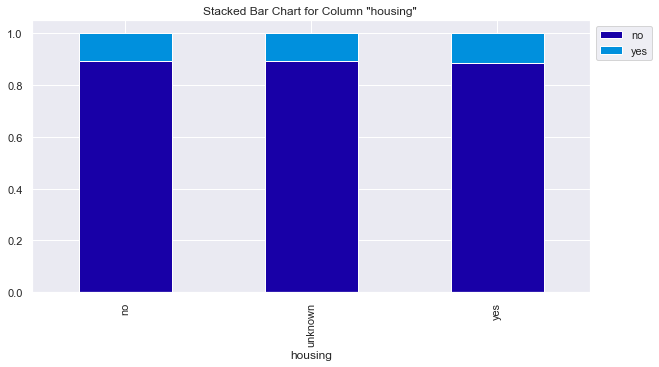

Breakdown for column "loan" 
y           no   yes    All
loan                       
no       30029  3836  33865
unknown    882   107    989
yes       5552   681   6233
All      36463  4624  41087
------------------------------------------------------------------------------------------------------------------------


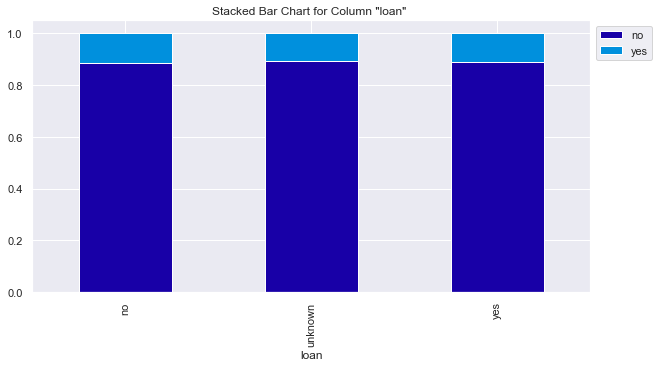

Breakdown for column "contact" 
y             no   yes    All
contact                      
cellular   22234  3839  26073
telephone  14229   785  15014
All        36463  4624  41087
------------------------------------------------------------------------------------------------------------------------


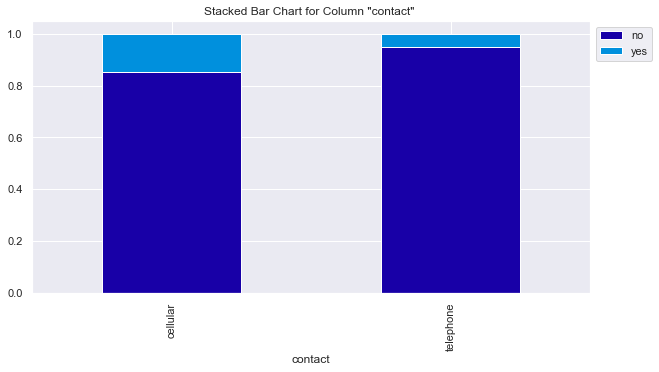

Breakdown for column "month" 
y         no   yes    All
month                    
apr     2089   538   2627
aug     5512   649   6161
dec       93    89    182
jul     6513   647   7160
jun     4748   558   5306
mar      269   274    543
may    12849   884  13733
nov     3675   415   4090
oct      401   314    715
sep      314   256    570
All    36463  4624  41087
------------------------------------------------------------------------------------------------------------------------


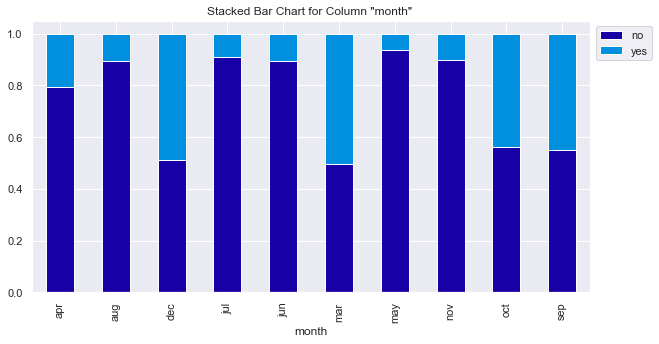

Breakdown for column "day_of_week" 
y               no   yes    All
day_of_week                    
fri           6967   844   7811
mon           7650   844   8494
thu           7553  1040   8593
tue           7119   952   8071
wed           7174   944   8118
All          36463  4624  41087
------------------------------------------------------------------------------------------------------------------------


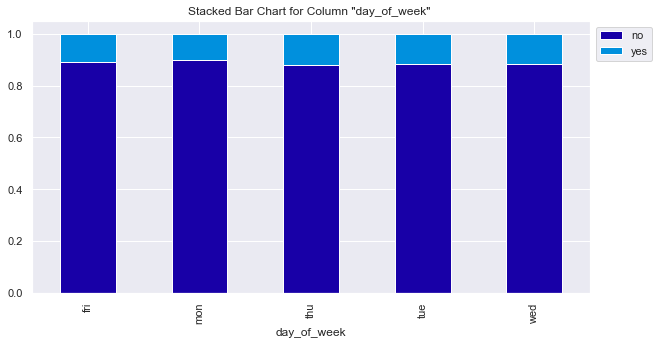

Breakdown for column "poutcome" 
y               no   yes    All
poutcome                       
failure       3633   604   4237
nonexistent  32353  3130  35483
success        477   890   1367
All          36463  4624  41087
------------------------------------------------------------------------------------------------------------------------


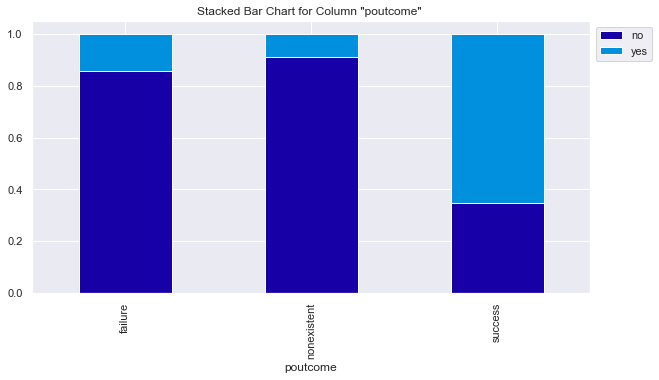

In [43]:
for column in cat_features:
    stacked_plot(df[column])

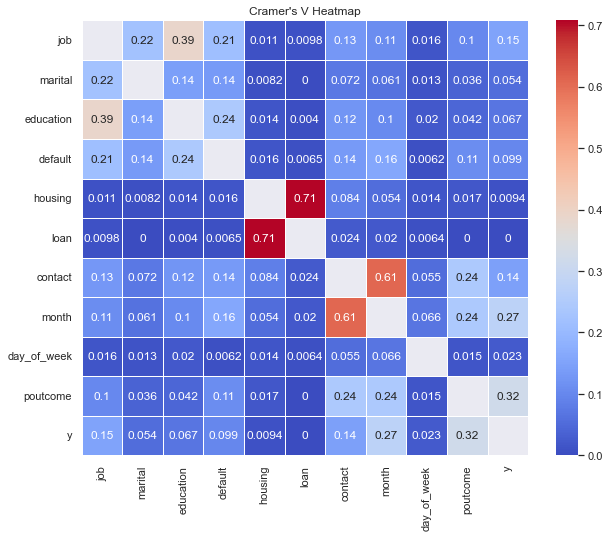

In [44]:
#Let us als render a Cramer's V association heatmap to see the association between the categorical variables 

# Automatically detect categorical columns
categorical_cols = df.select_dtypes(include=['object', 'category']).columns

# Define a function to calculate Cramer's V
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

# Calculate Cramer's V for each pair of categorical variables
cramer_matrix = pd.DataFrame(index=categorical_cols, columns=categorical_cols, dtype=float)
for col1 in categorical_cols:
    for col2 in categorical_cols:
        if col1 != col2:
            cramer_matrix.at[col1, col2] = cramers_v(df[col1], df[col2])

# Create a heatmap chart
plt.figure(figsize=(10, 8))
sns.heatmap(cramer_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Cramer's V Heatmap")
plt.show()




## Observations:
The following Categorical columns have significant impact on the "y" (the outcome):
- job
- default
- contact
- month
- poutcome

These two have very weak association with "y", but let us not delete them just yet:
- education
- marital

The following Categorical variables appear to have no impact (or negligible impact) on "y". Therefore, we will delete these columns, since they do not appear to be useful in future modeling.
- housing
- loan
- day_of_week

"contact" and "month" have high Cramer's V association, which could create multicollinearity and offerfitting with some of our models. Let us delete one of these variabels> i chose Contact, sinc it has the weakest association with "y" among the two

In [46]:
df.drop(['housing', 'loan', 'day_of_week', 'contact' ], axis =1, inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41087 entries, 0 to 41187
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41087 non-null  int64  
 1   job             41087 non-null  object 
 2   marital         41087 non-null  object 
 3   education       41087 non-null  object 
 4   default         41087 non-null  object 
 5   month           41087 non-null  object 
 6   duration        41087 non-null  int64  
 7   campaign        41087 non-null  int64  
 8   pdays           41087 non-null  int64  
 9   previous        41087 non-null  int64  
 10  poutcome        41087 non-null  object 
 11  emp.var.rate    41087 non-null  float64
 12  cons.price.idx  41087 non-null  float64
 13  cons.conf.idx   41087 non-null  float64
 14  euribor3m       41087 non-null  float64
 15  nr.employed     41087 non-null  float64
 16  y               41087 non-null  object 
dtypes: float64(5), int64(5), object

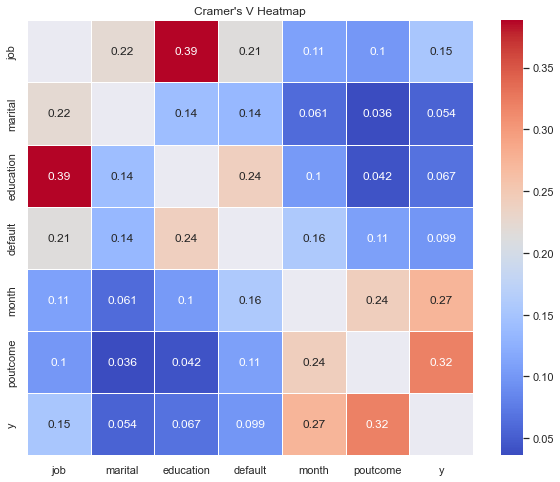

In [47]:
#Let us als render a Cramer's V again

# Automatically detect categorical columns
categorical_cols = df.select_dtypes(include=['object', 'category']).columns

# Define a function to calculate Cramer's V
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

# Calculate Cramer's V for each pair of categorical variables
cramer_matrix = pd.DataFrame(index=categorical_cols, columns=categorical_cols, dtype=float)
for col1 in categorical_cols:
    for col2 in categorical_cols:
        if col1 != col2:
            cramer_matrix.at[col1, col2] = cramers_v(df[col1], df[col2])

# Create a heatmap chart
plt.figure(figsize=(10, 8))
sns.heatmap(cramer_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Cramer's V Heatmap")
plt.show()

# Analysis of Numerical Features and Their Impact on "y"

## Pairplot

In [48]:
# Separating numerical variables
numerical_col = df.select_dtypes(include='number').columns.tolist()

## Correlation Heatmap

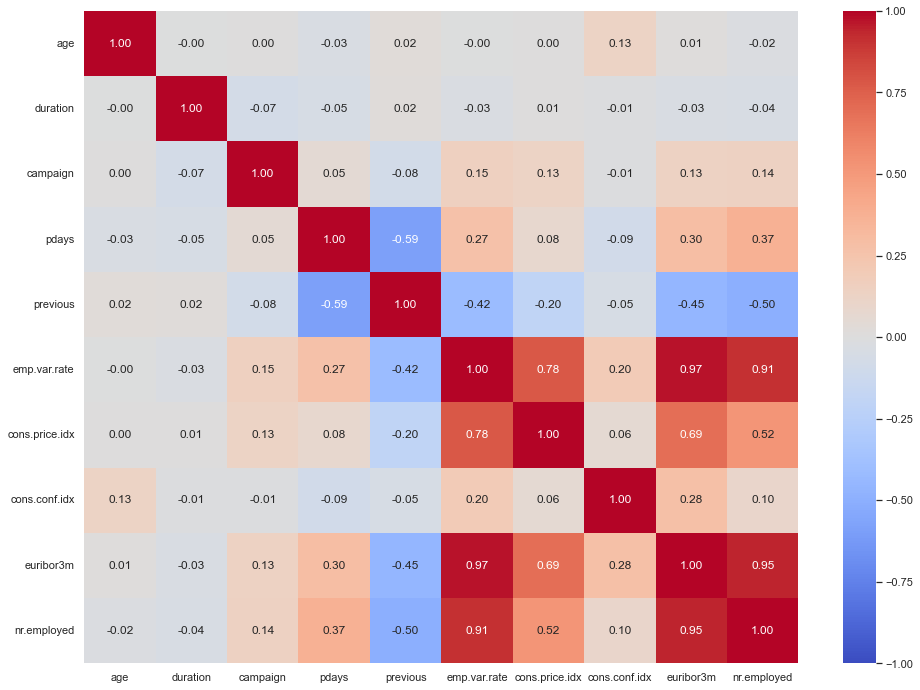

In [49]:
#Correlation Matrix
corr = df[numerical_col].corr()

# plot the heatmap

plt.figure(figsize=(16,12))
sns.heatmap(corr,cmap='coolwarm',vmax=1,vmin=-1,
        fmt=".2f", annot=True,
        xticklabels=corr.columns,
        yticklabels=corr.columns);

### Observations:
The following numerical columns have very high correlation, which could cause multi-collinearity:

- emp.var.rate and euribor3m (0.97)
- nr.employed and euribor3m (0.95)
- emp.var.rate and nr.employed (0.91)
- emp.var.rate and cons.price.idx (0.78)

Some of the models that we will use will be sensitive to Multicollinearity. Therefore, we might have to figure out what to do with these columns. 

## Variance Inflation Factor (VIF)

In [50]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [51]:
# A function to calculate VIF
def calculate_vif(data_frame):
    vif_data = pd.DataFrame()
    vif_data["Variable"] = data_frame.columns
    vif_data["VIF"] = [variance_inflation_factor(data_frame.values, i) for i in range(data_frame.shape[1])]
    return vif_data

In [52]:
numerical_data = df[numerical_col]
vif_result = calculate_vif(numerical_data)
print(vif_result)

         Variable           VIF
0             age     16.051236
1        duration      2.010882
2        campaign      1.921944
3           pdays     44.486555
4        previous      2.002107
5    emp.var.rate     28.905777
6  cons.price.idx  22563.812435
7   cons.conf.idx    120.165496
8       euribor3m    226.340845
9     nr.employed  26753.070341


### Observation:
- Some of the numerical columns, especially nr.employed and cons.price.idx have an insanely-high VIF. We will have to get rid of these columns before applying models that are sencitive to Multicollinearity. 

Here is how Multicollinearity can affect the models that we will try:
    
1. **Logistic Regression** is sensitive to multicollinearity. 

2. **K Nearest Neighbors (KNN)** is generally robust to Multicollinearity because it relies on distances between data points rather than linear relationships between predictors. However, Multicollinearity can still impact KNN indirectly if it leads to noise in the data or if it makes the choice of an appropriate distance metric more challenging.

3. **Decision Tree** is typically less sensitive to multicollinearity. However, Multicollinearity can still affect feature selection and tree structure.

4. **Support Vector Machines (SVM)** is relatively robust to Multicollinearity, particularly when using non-linear kernel functions.

# Univariate Analysis - Numerical Variables

In [53]:
# Let us write a function that will help us create boxplot and histogram for any input numerical variable.
# This function takes the numerical column as the input and return the boxplots and histograms for the variable.
def histogram_boxplot(feature, data=None, figsize=(15, 10), bins=None):
    """ Boxplot and histogram combined
    feature: 1-d feature array
    data: DataFrame containing the feature (default None)
    figsize: size of fig (default (9,8))
    bins: number of bins (default None / auto)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(nrows=2,
                                           sharex=True,
                                           gridspec_kw={"height_ratios": (.25, .75)},
                                           figsize=figsize)
    sns.boxplot(data=data, x=feature, ax=ax_box2, showmeans=True, color='violet')
    if bins:
        sns.histplot(data=data, x=feature, kde=False, ax=ax_hist2, bins=bins, palette="winter")
    else:
        sns.histplot(data=data, x=feature, kde=False, ax=ax_hist2, palette="winter")
    ax_hist2.axvline(data[feature].mean(), color='green', linestyle='--')
    ax_hist2.axvline(data[feature].median(), color='black', linestyle='-')
    
    # Set the chart title based on the feature name
    f2.suptitle(f'Histogram and Boxplot for {feature}', fontsize=16)

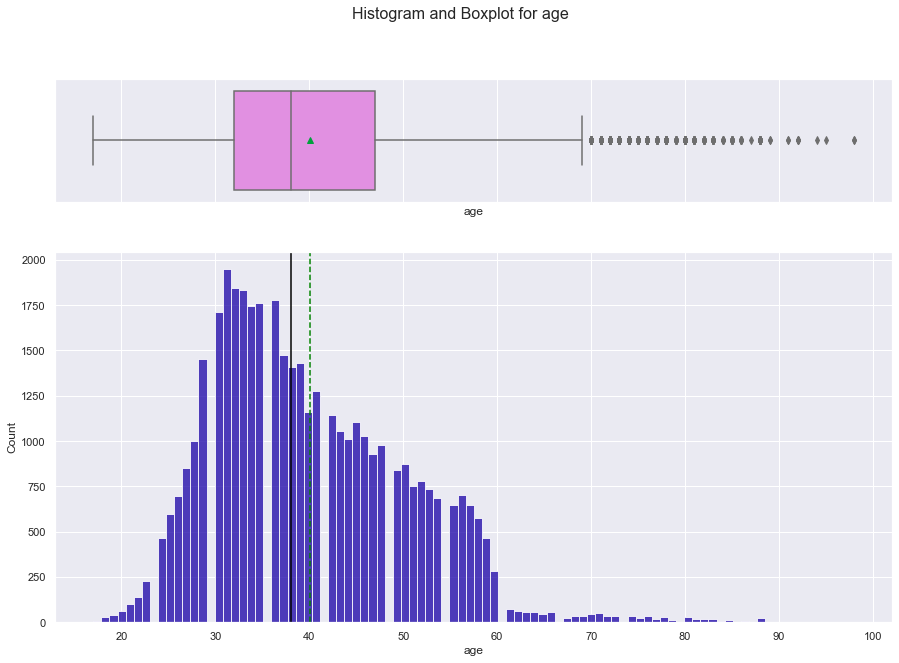

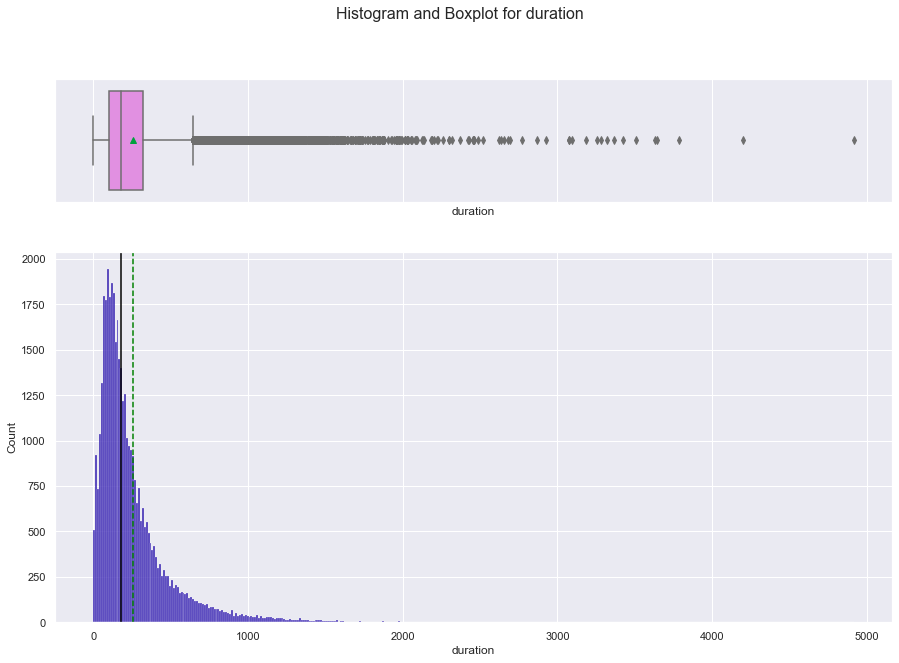

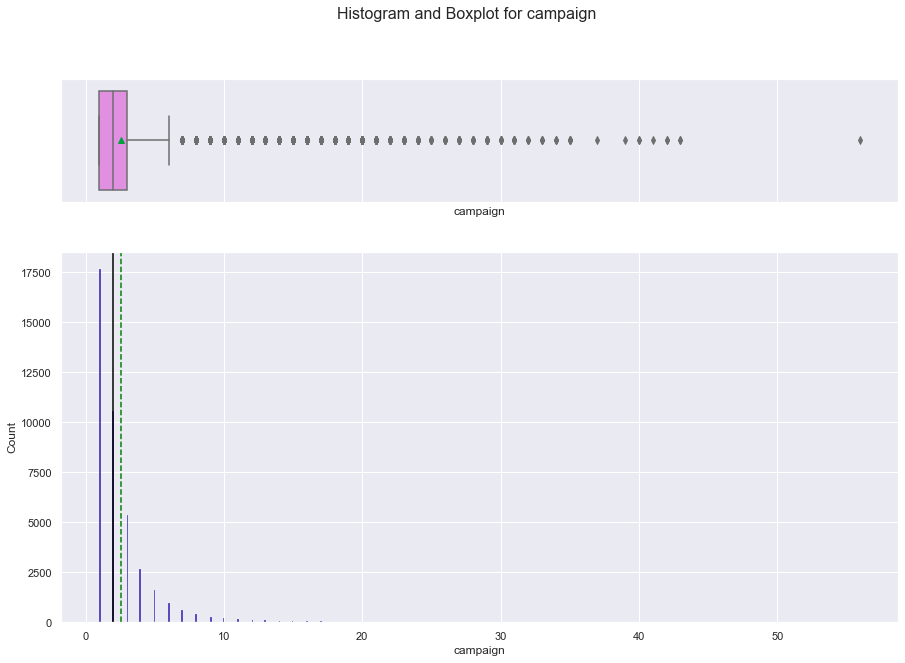

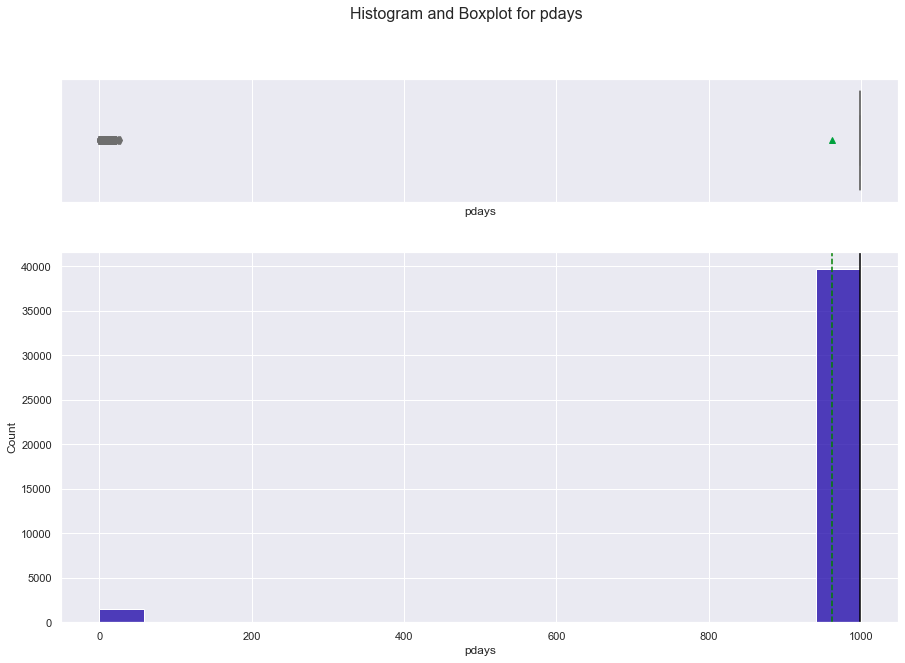

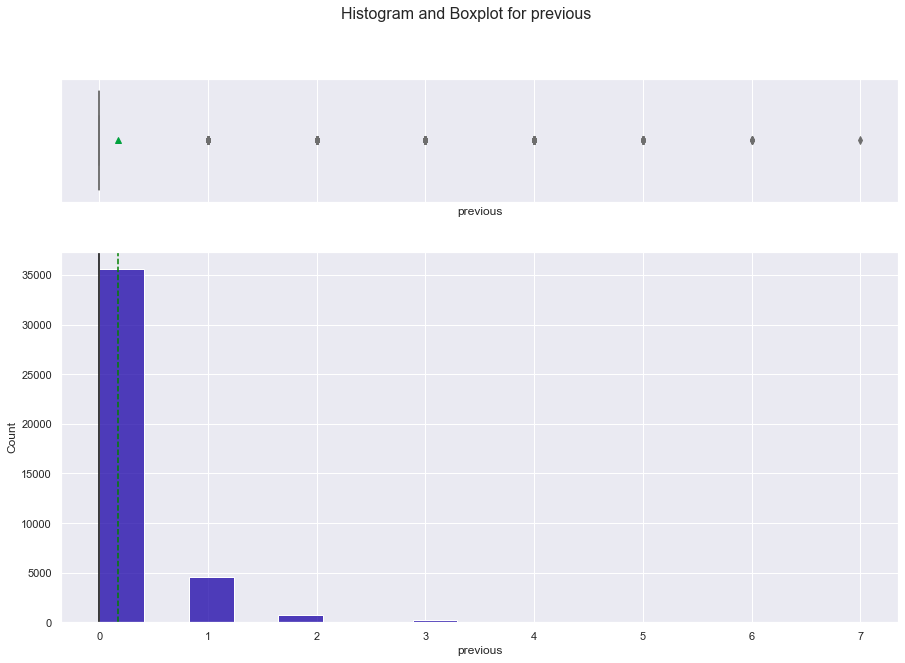

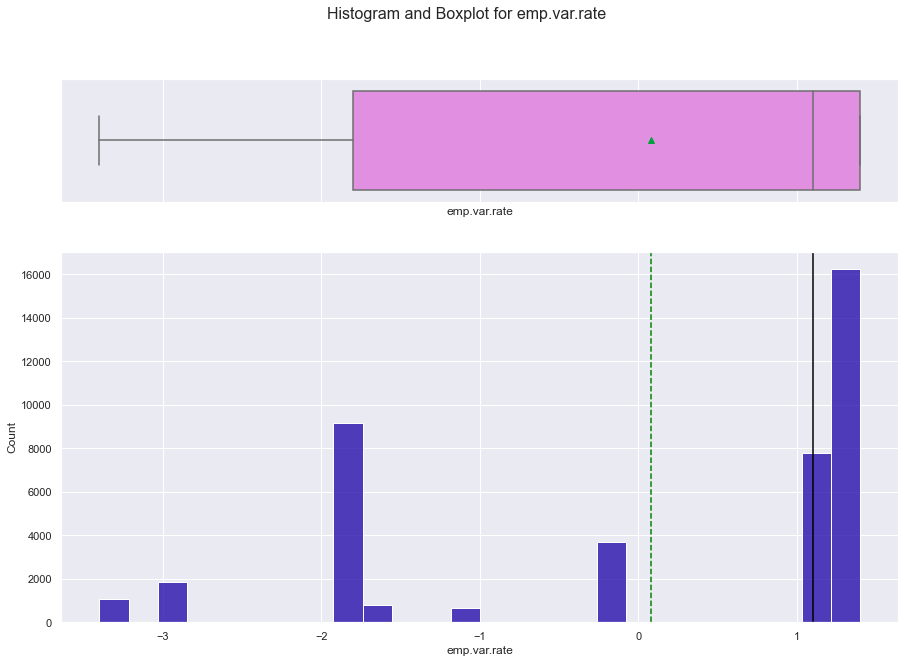

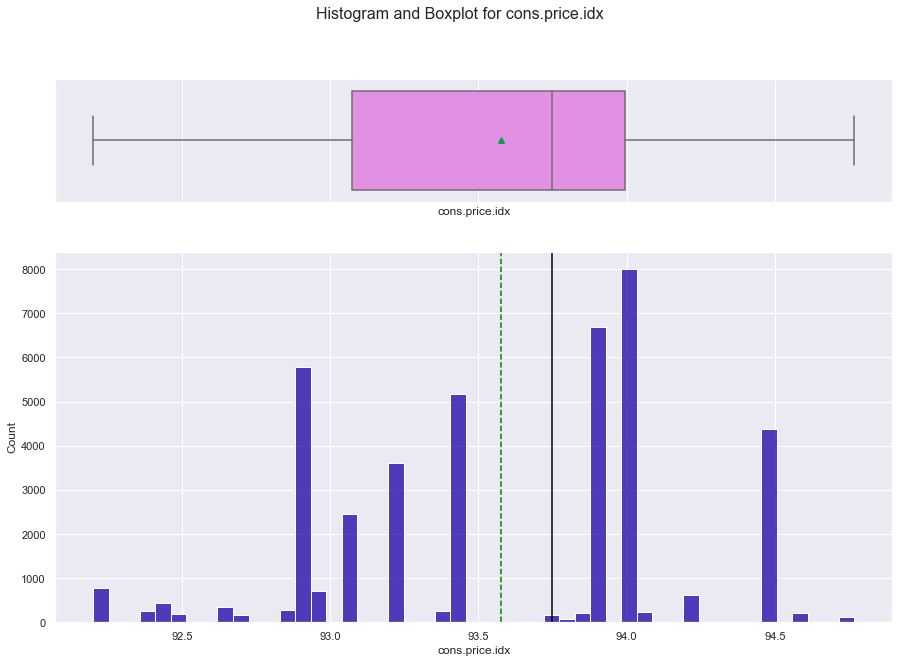

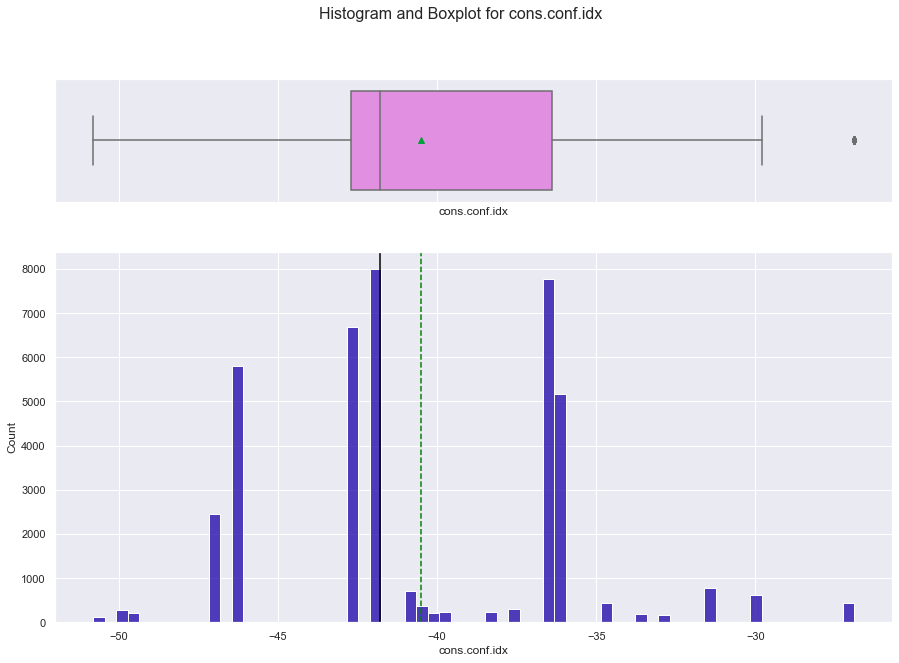

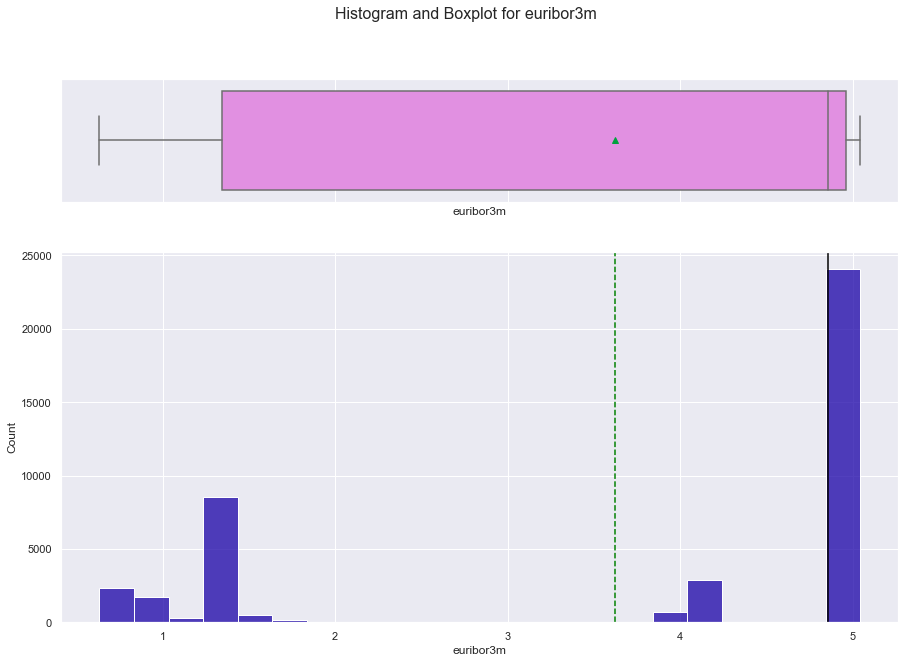

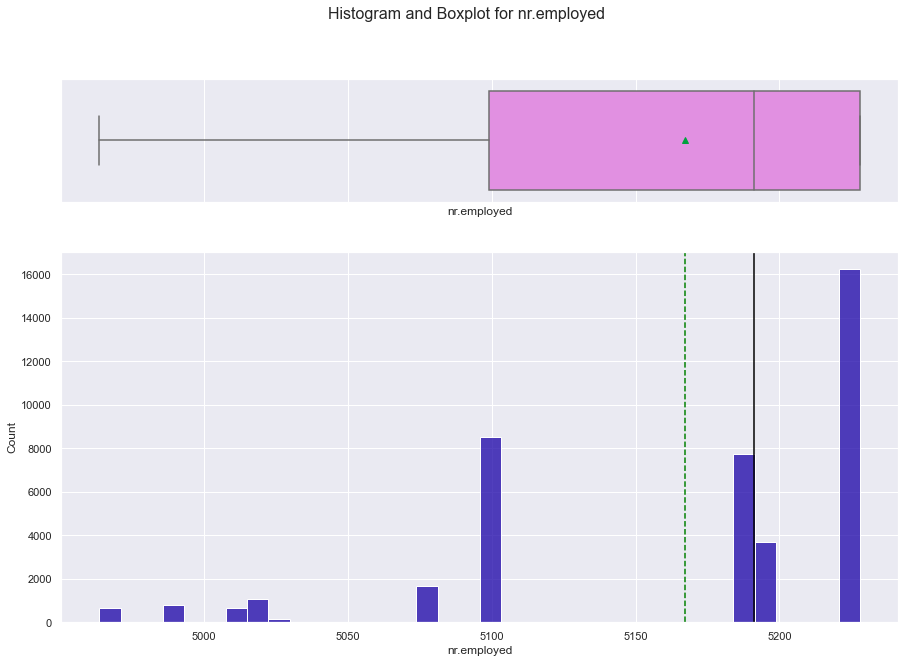

In [19]:
# Build the histogram boxplots for all numerical columns
for col in numerical_col:
    histogram_boxplot(col, data=df)

## Observations:
- Age, Duration, Campaign, and Previous  are right-skewed with a lot of outliers.
- P-days have a bimodal distribution where most of the records fall under very high values and a few have low values
- Emp.var.rate, cons.price.idx, cons.conf.idx, euribor3m, and nr.employed have irregular multi-modal distributions

Out of the four models that we will try, In summary, KNN and Decision Trees are relatively more sensitive to outliers. So we will have to treat the outliers before building these models

Logistic regression and SVMs tend to be more robust to outliers.


# Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

As stated in the description, the classification goal is to predict if the client will subscribe to a term deposit (variable y).

Knowing the Marketing / Advertising industry, I imagine that the model will be used to predict which prospects to target to convert them into subscribers. 

Assuming that the bank earns a significant amount from every subscriber, I believe that **Recall** should be the primary metric of the classification model. I.e., we will need to help the bank to identify as many qualified prospects as possible to be targeted with the marketing campaign. 

Another argument in favor of prioritizing Recall is the fact that the classes are highly imbalanced. Only 11.2% fall under Class 1. It is a scarce class, and we want to identify as many of potential good prospects as possible. 

The above is an assumption. Ultimately, it is up to the Business Managers (and not Data Scientists) to decide what is more important. 


# Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features (columns 1 - 7), prepare the features and target column for modeling with appropriate encoding and transformations.

As discussed earlier, we will need to transform the data as follows:

1) Do a Log transformation for Campaign, and Duration which are highly right-skewed.

2) Address Multicollinearity by removing some of the high VIF features before building Logistic Regression and KNN.

3) Treat the outliers before buildiung KNN and Decision Trees

## 1. Log transformation for Campaign and Duration

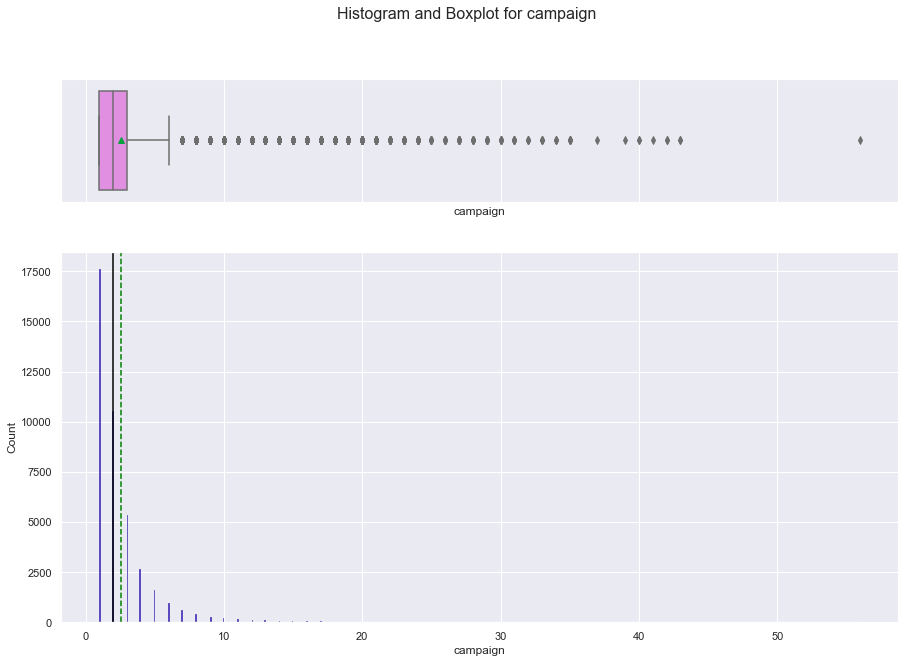

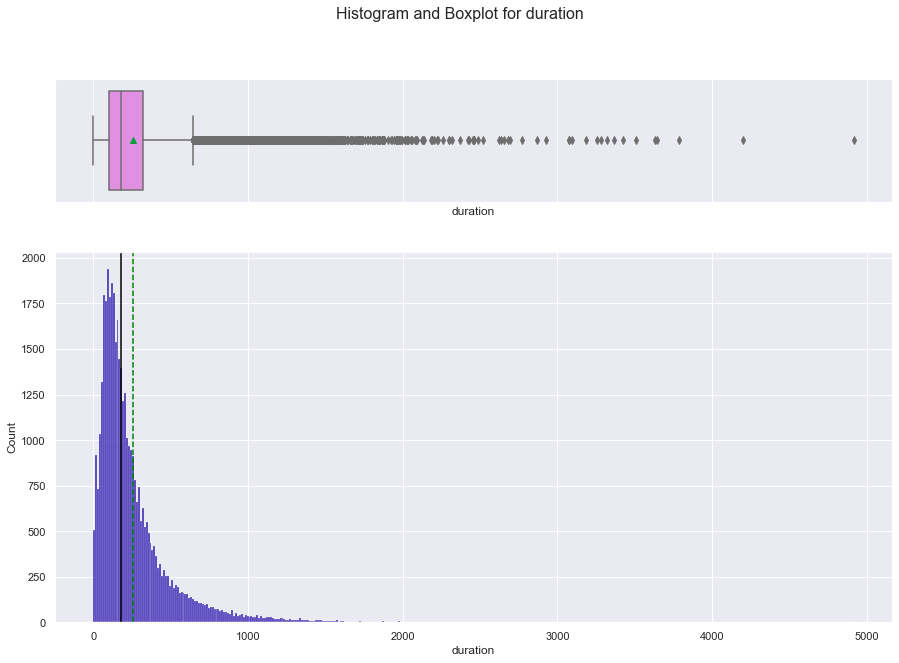

In [54]:
# Once again, let us render the distribution of the original Campaign and Duration feature:
histogram_boxplot('campaign', data=df)
histogram_boxplot('duration', data=df)

In [55]:
df['camp_log'] = np.log(df['campaign'])

In [56]:
#It appears that some values for "duration" could be equal to zero
#Let's look at min and max value for "duration"
min_duration = df['duration'].min()
max_duration = df['duration'].max()

print(f"Minimum Duration: {min_duration}")
print(f"Maximum Duration: {max_duration}")

Minimum Duration: 0
Maximum Duration: 4918


Indeed, Min is equal to 0. Since we can't do log transforfamtion of 0, let us replace 0 with a tiny value

In [57]:
df['duration'] = df['duration'].replace(0, 1)

In [58]:
#now we can do the Log transformation
df['dur_log'] = np.log(df['duration'])

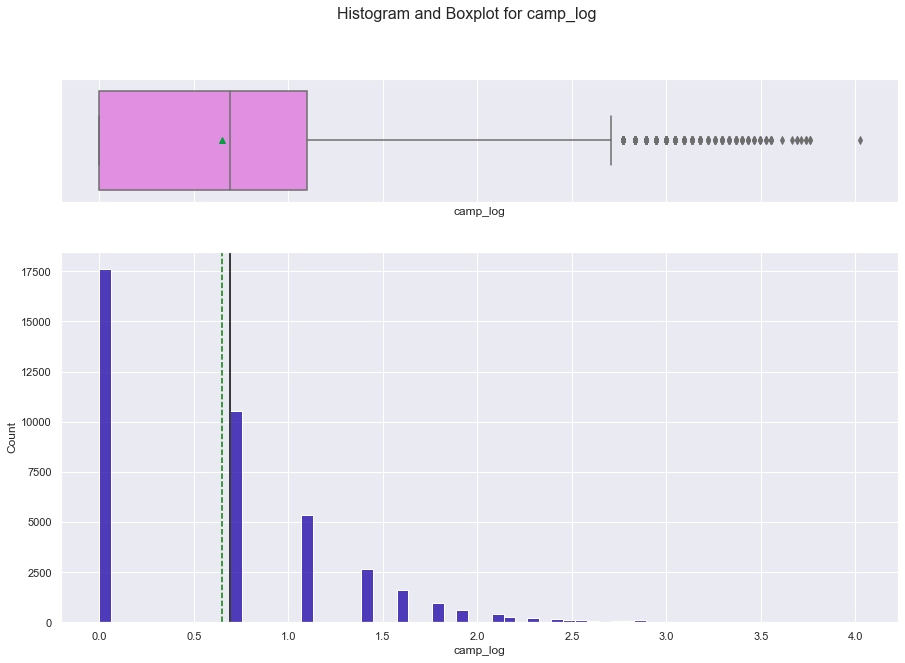

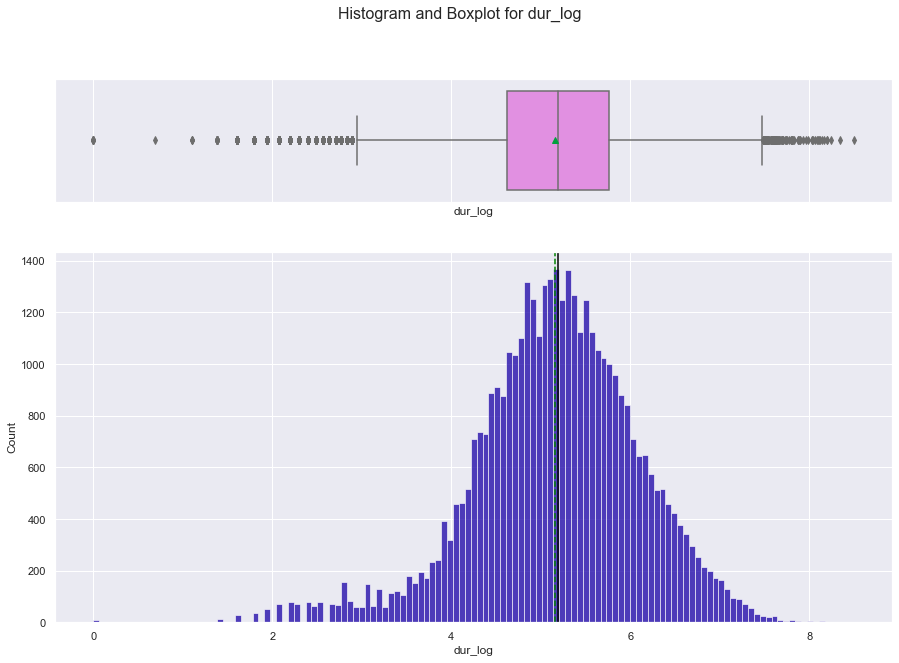

In [59]:
#Let's see how the new features are distributed:
histogram_boxplot('camp_log', data=df)
histogram_boxplot('dur_log', data=df)

**Observation:**
The "Campaign Log" feature is still skewed, but not as badly than the original feature. 
The "Duration Log " feature distribution looks a lot more like Normal.

In [60]:
# Let us drop the original features
df.drop(['campaign', 'duration'], axis =1, inplace = True)

## 2. Address Multicollinearity by removing some of the high VIF features before building Logistic Regression and KNN.

In [61]:
# Next, let us create a new dataframe that addresses the multicollinearity issue (to be used for Logistic Regression and KNN)
# For convenience, let us look at VIF again (after we applied the earlier transformations)
numerical_col = df.select_dtypes(include='number').columns.tolist()
numerical_data = df[numerical_col]
vif_result = calculate_vif(numerical_data)
print(vif_result)

         Variable           VIF
0             age     16.050324
1           pdays     44.520869
2        previous      2.001422
3    emp.var.rate     29.018728
4  cons.price.idx  22625.311461
5   cons.conf.idx    120.172944
6       euribor3m    226.955736
7     nr.employed  26770.015405
8        camp_log      1.984080
9         dur_log     32.862368


In [62]:
#Let us now create a new dataframe, in which we will drop features that cause multicollinearity (one by one)
df_no_mc = df.drop('nr.employed', axis=1)
numerical_col = df_no_mc.select_dtypes(include='number').columns.tolist()
numerical_data = df_no_mc[numerical_col]
vif_result = calculate_vif(numerical_data)
print(vif_result)

         Variable         VIF
0             age   16.049668
1           pdays   43.758843
2        previous    1.989094
3    emp.var.rate   19.979324
4  cons.price.idx  341.124550
5   cons.conf.idx  100.987351
6       euribor3m  119.046325
7        camp_log    1.979132
8         dur_log   32.854608


In [63]:
# "cons.price.idx" has the highes VIF score now. Let us drop it next
df_no_mc.drop('cons.price.idx', axis=1, inplace=True)
numerical_col = df_no_mc.select_dtypes(include='number').columns.tolist()
numerical_data = df_no_mc[numerical_col]
vif_result = calculate_vif(numerical_data)
print(vif_result)

        Variable        VIF
0            age  14.905599
1          pdays  41.806645
2       previous   1.819429
3   emp.var.rate  11.829054
4  cons.conf.idx  50.140509
5      euribor3m  61.331376
6       camp_log   1.953769
7        dur_log  28.816950


In [64]:
#Now let us drop euribor3m column, sinc it has the highest VIF:
df_no_mc.drop('euribor3m', axis=1, inplace=True)
numerical_col = df_no_mc.select_dtypes(include='number').columns.tolist()
numerical_data = df_no_mc[numerical_col]
vif_result = calculate_vif(numerical_data)
print(vif_result)

        Variable        VIF
0            age  13.701710
1          pdays  35.544582
2       previous   1.808737
3   emp.var.rate   1.275758
4  cons.conf.idx  48.073137
5       camp_log   1.951544
6        dur_log  25.375146


In [65]:
#"cons.conf.idx" is the column with the highest VIF. Let us drop it next:
df_no_mc.drop('cons.conf.idx', axis=1, inplace=True)
numerical_col = df_no_mc.select_dtypes(include='number').columns.tolist()
numerical_data = df_no_mc[numerical_col]
vif_result = calculate_vif(numerical_data)
print(vif_result)

       Variable        VIF
0           age  13.283222
1         pdays  21.099929
2      previous   1.628628
3  emp.var.rate   1.241240
4      camp_log   1.907165
5       dur_log  20.417885


In [66]:
#"pdays" is now the column with teh highest VIF. Let us kill it and see what happens:
df_no_mc.drop('pdays', axis=1, inplace=True)
numerical_col = df_no_mc.select_dtypes(include='number').columns.tolist()
numerical_data = df_no_mc[numerical_col]
vif_result = calculate_vif(numerical_data)
print(vif_result)

       Variable        VIF
0           age  11.198589
1      previous   1.365037
2  emp.var.rate   1.240065
3      camp_log   1.846657
4       dur_log  11.061359


In [67]:
# Let us drop "age" next
df_no_mc.drop('age', axis=1, inplace=True)
numerical_col = df_no_mc.select_dtypes(include='number').columns.tolist()
numerical_data = df_no_mc[numerical_col]
vif_result = calculate_vif(numerical_data)
print(vif_result)

       Variable       VIF
0      previous  1.362198
1  emp.var.rate  1.239547
2      camp_log  1.795608
3       dur_log  1.928799


In [68]:
# we eliminated Multicollinearity from our new dataframe. let us save its output as a .csv file
df_no_mc.to_csv('df_no_mc.csv', index=False)

We will use the saved dataset for Logistic Regression, which would be sensitive to Multicollinearity

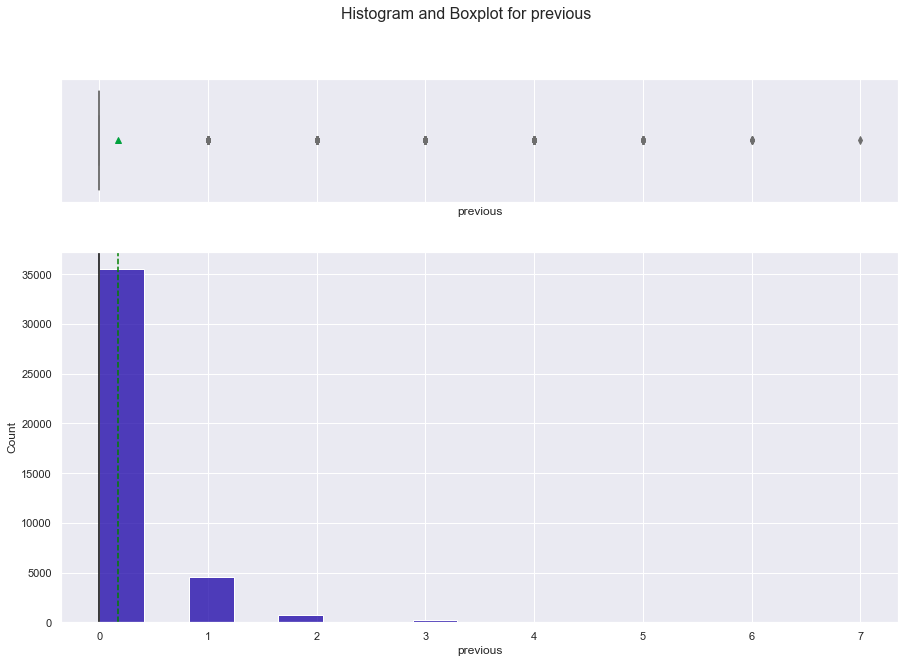

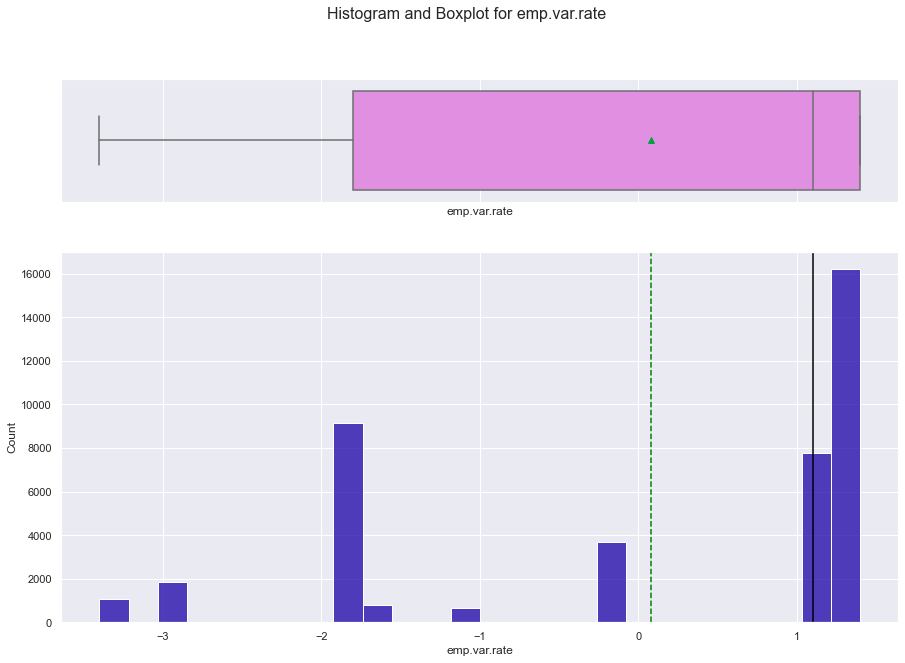

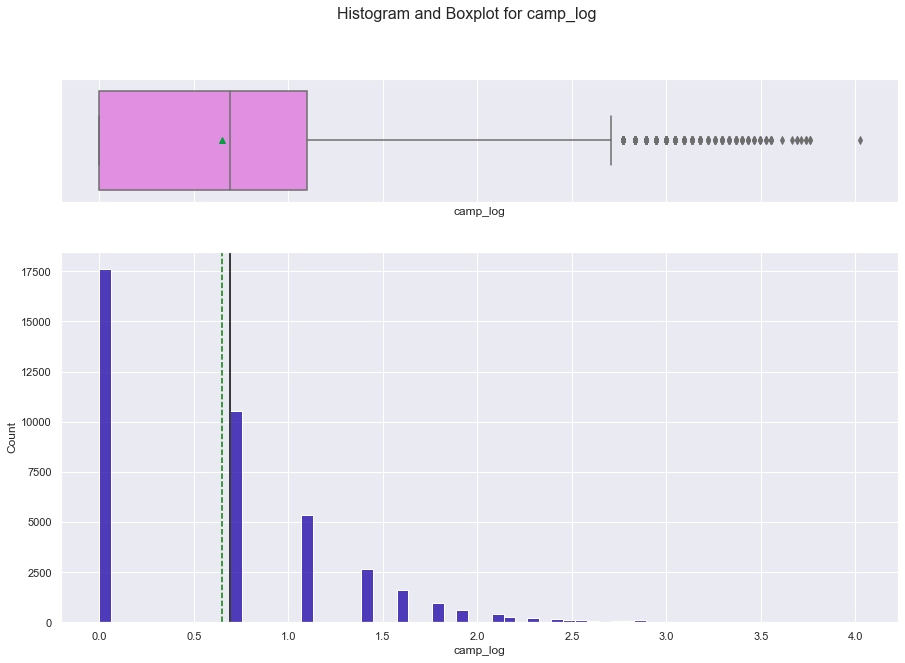

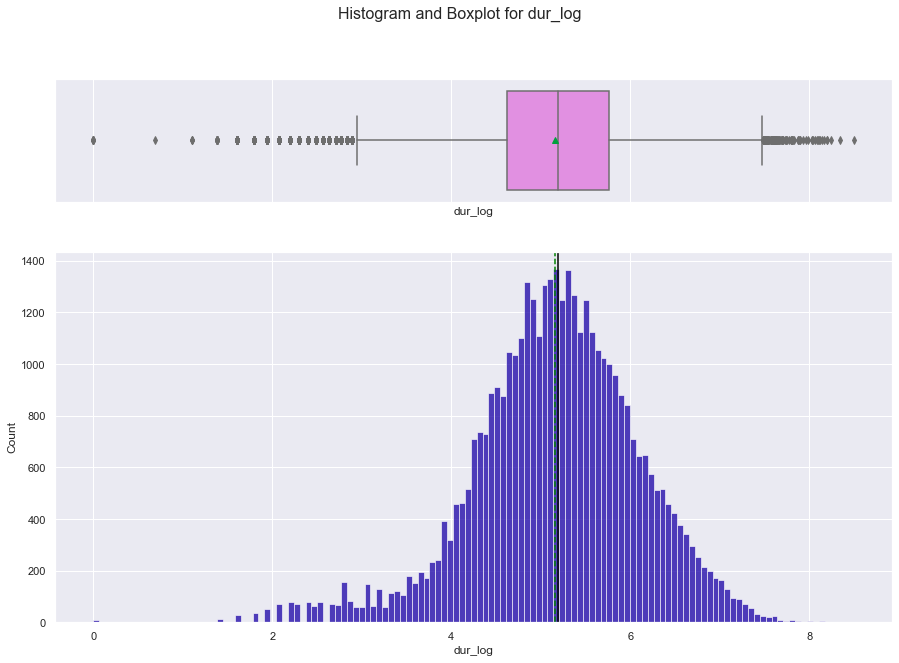

In [69]:
# Build the histogram boxplots for all numerical columns
for col in numerical_col:
    histogram_boxplot(col, data=df)

## 3. Treat the outliers

From the four models that we are going to try:

**1. K-Nearest Neighbors (KNN):** KNN is sensitive to outliers

**2. Logistic Regression:** Logistic regression is relatively robust to outliers.

**3. Support Vector Machines (SVM):** SVMs are generally less sensitive to outliers due to their use of support vectors to define the decision boundary. Outliers located far from the decision boundary may not have a significant effect on the model. Nevertheless, extreme outliers close to the boundary can influence the margin and support vectors, potentially affecting the model's performance.

**4. Decision Tree:** Decision trees can be sensitive to outliers, particularly when the tree is deep and overfits the data. Outliers can lead to the creation of overly complex branches to accommodate them, resulting in a less interpretable and potentially overfit model. Pruning or limiting the tree's depth can help mitigate the impact of outliers.


In [70]:
df.describe()

,age,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,camp_log,dur_log
count,41087.000000,41087.000000,41087.000000,41087.000000,41087.000000,41087.000000,41087.000000,41087.000000,41087.000000,41087.000000
mean,40.019690,962.530362,0.172780,0.082510,93.575996,-40.502402,3.621859,5167.048935,0.649692,5.163268
std,10.419191,186.776559,0.494836,1.570734,0.578703,4.627195,1.734308,72.260910,0.692092,0.928327
min,17.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000,0.000000,0.000000
25%,32.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000,0.000000,4.624973
50%,38.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000,0.693147,5.192957
75%,47.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000,1.098612,5.765191
max,98.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000,4.025352,8.500657


In [71]:
# We will use the original dataset "df" and will use the IQR method 

# Once again, we will select numerical columns from the original dataframe
numerical_cols = df.select_dtypes(include='number').columns.tolist()

# Create a copy of the original DataFrame
df_no_outliers = df.copy()

# Define a function to treat outliers using IQR
def treat_outliers_iqr(column):
    Q1 = df_no_outliers[column].quantile(0.25)
    Q3 = df_no_outliers[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Replace outliers with NaN or any other value as needed
    df_no_outliers[column] = df_no_outliers[column].apply(lambda x: x if lower_bound <= x <= upper_bound else None)

# Apply the IQR-based outlier treatment to each numerical column
for col in numerical_cols:
    treat_outliers_iqr(col)


In [72]:
df_no_outliers.describe()

,age,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,camp_log,dur_log
count,40619.000000,39578.0,35483.0,41087.000000,41087.000000,40642.000000,41087.000000,41087.000000,40734.000000,40022.000000
mean,39.594525,999.0,0.0,0.082510,93.575996,-40.651339,3.621859,5167.048935,0.628934,5.222624
std,9.672540,0.0,0.0,1.570734,0.578703,4.426878,1.734308,72.260910,0.657621,0.823338
min,17.000000,999.0,0.0,-3.400000,92.201000,-50.800000,0.634000,4963.600000,0.000000,2.944439
25%,32.000000,999.0,0.0,-1.800000,93.075000,-42.700000,1.344000,5099.100000,0.000000,4.672829
50%,38.000000,999.0,0.0,1.100000,93.749000,-41.800000,4.857000,5191.000000,0.693147,5.214936
75%,47.000000,999.0,0.0,1.400000,93.994000,-36.400000,4.961000,5228.100000,1.098612,5.777652
max,69.000000,999.0,0.0,1.400000,94.767000,-29.800000,5.045000,5228.100000,2.708050,7.470794


### Observation:
- Looks like Min and Max beame closer to the center, which is to be expected
- pdays and previous seem to contain only one value each (al other values seemed to have been removed as outliers
- now let us render the Histogram and the Box Plot for the new dataframe.

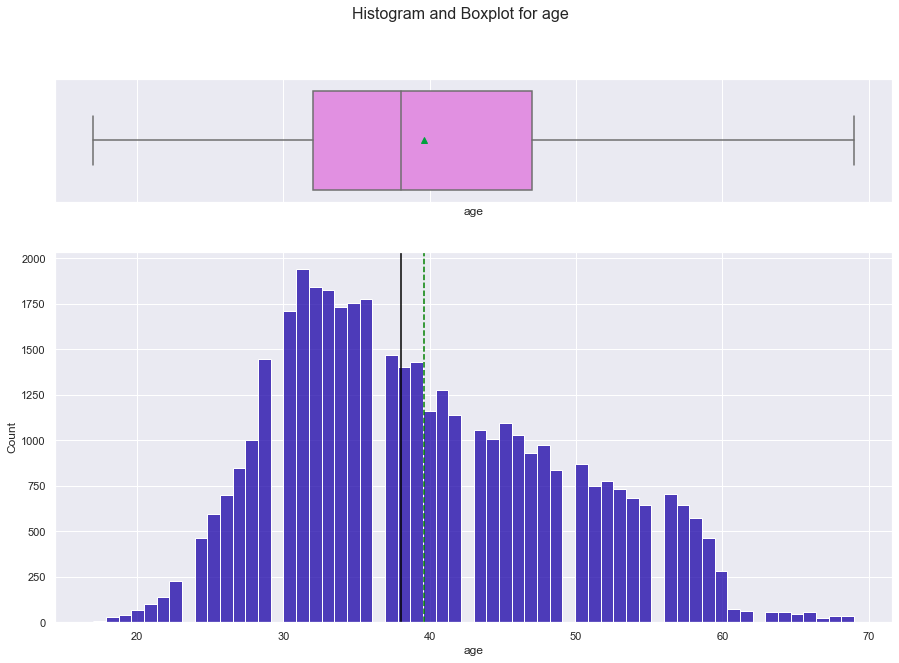

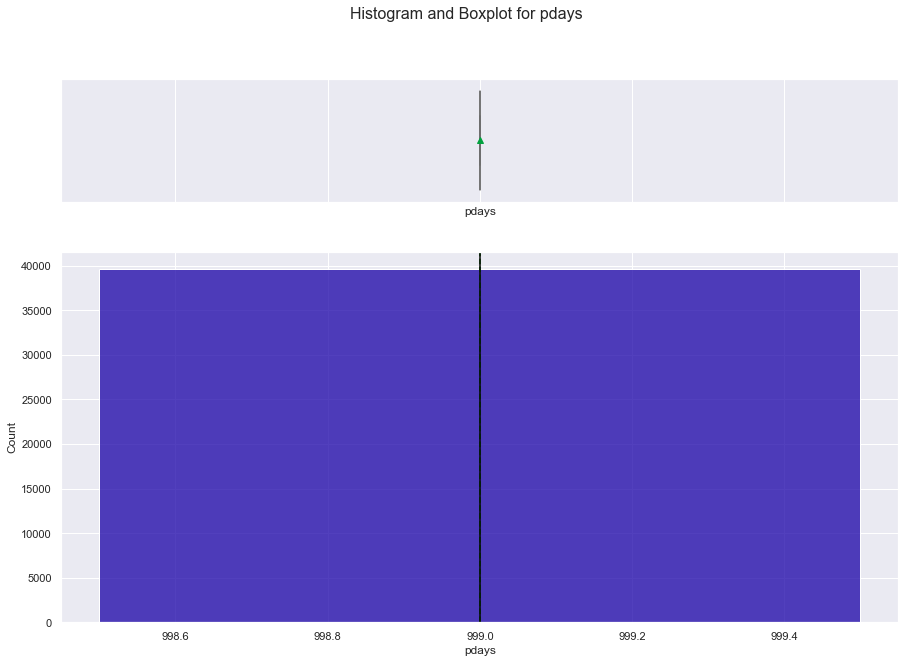

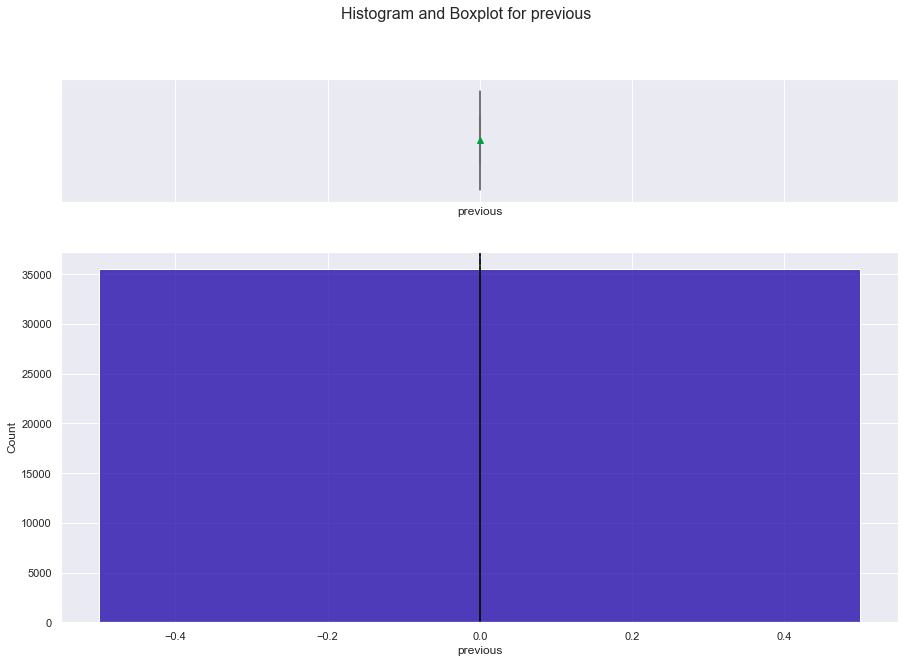

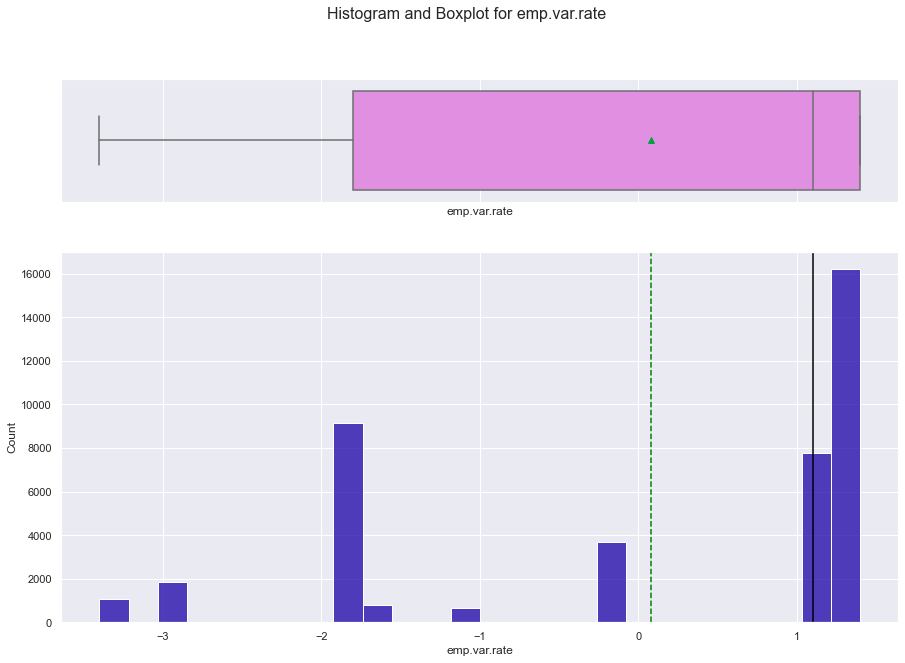

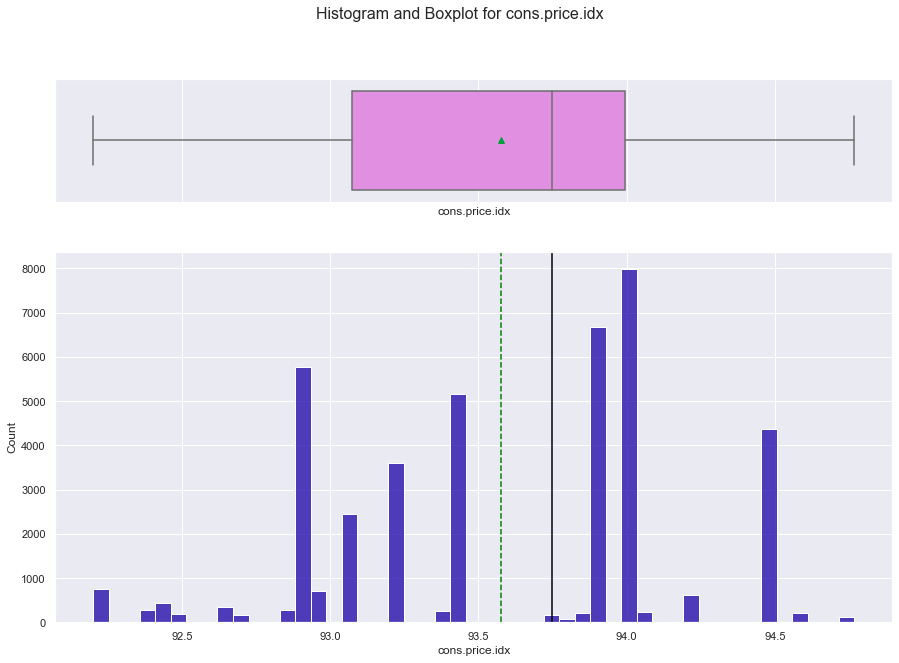

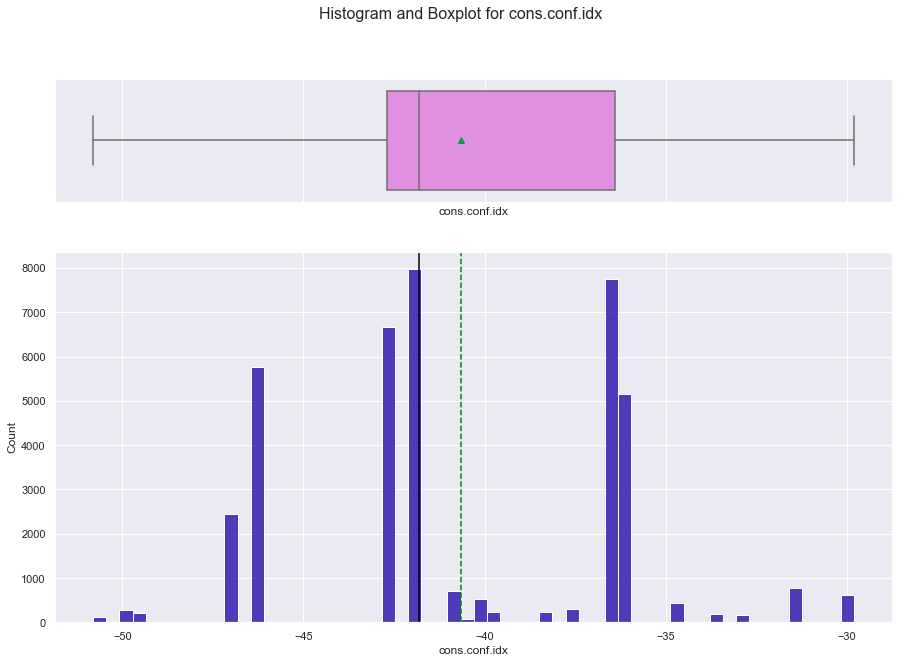

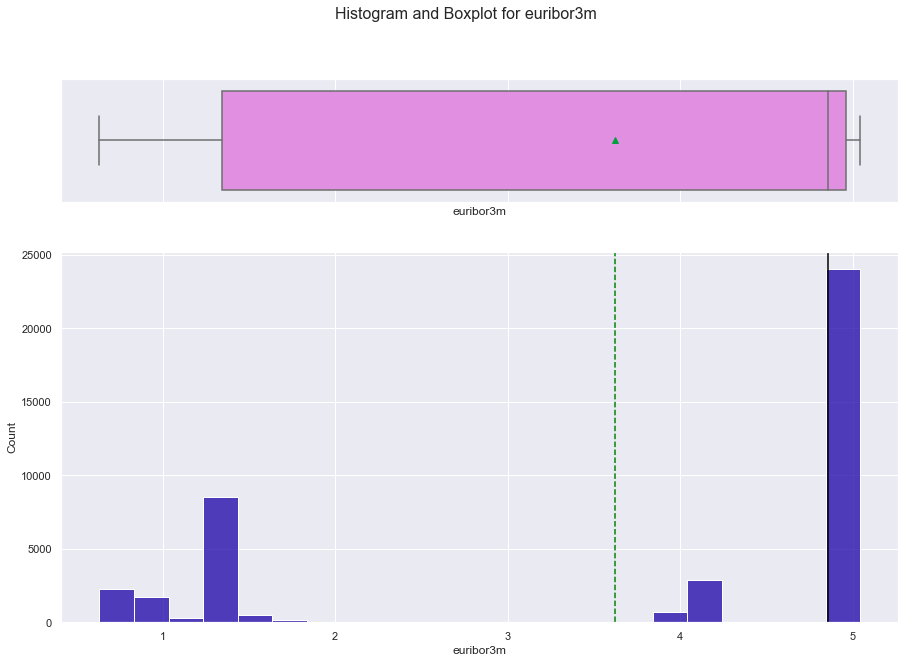

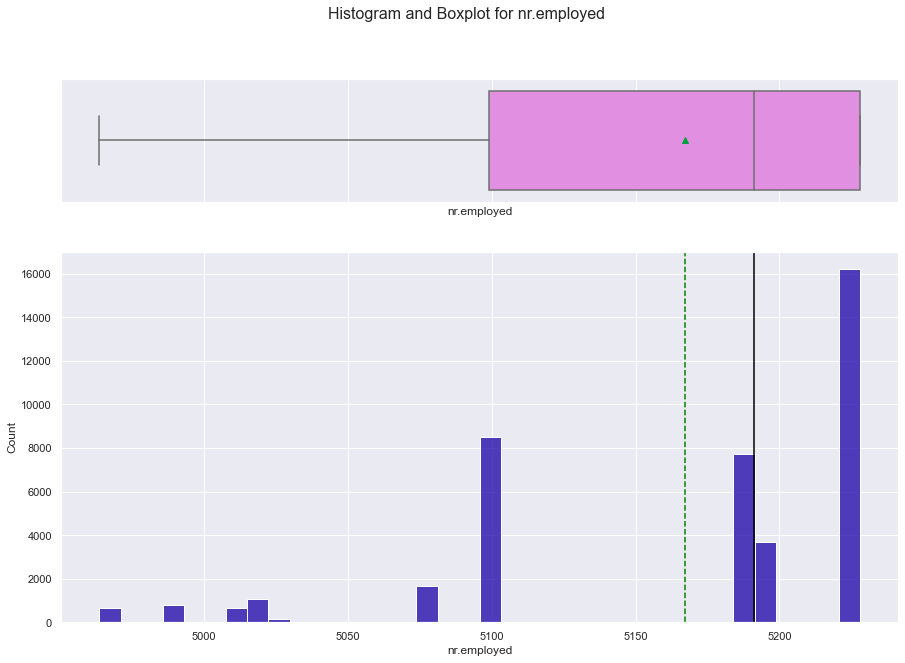

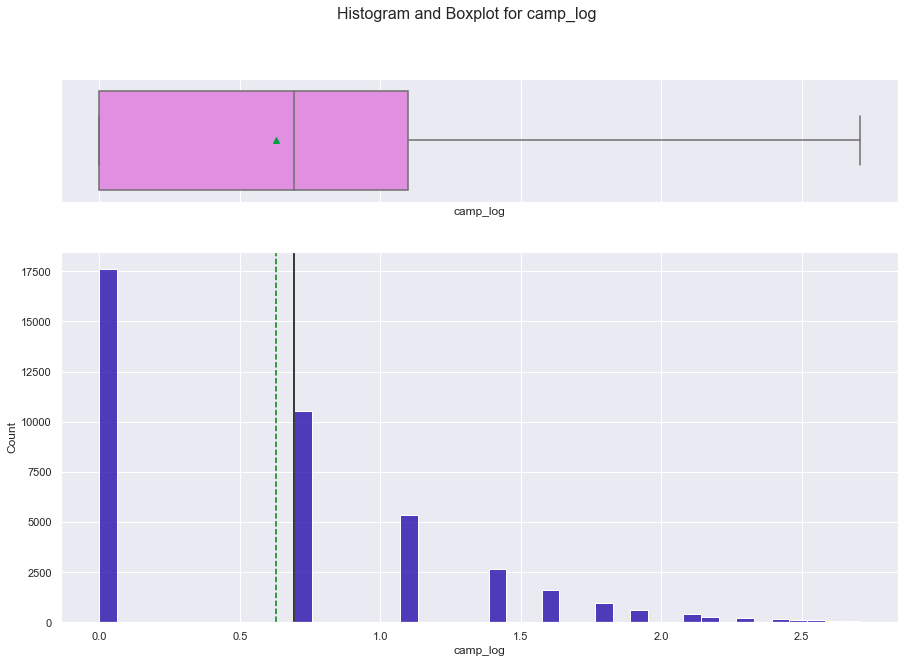

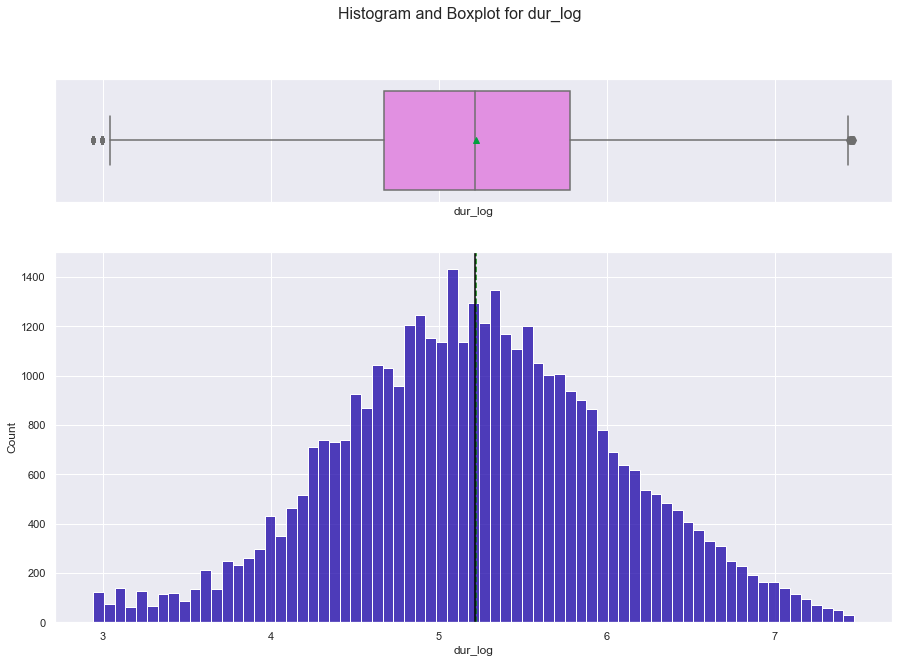

In [73]:
# Build the histogram boxplots for all numerical columns
for col in numerical_cols:
    histogram_boxplot(col, data=df_no_outliers)

### Observation:
- The outliders are successfully treated - for the most part
- However, due to the odd bimodal nature of 'pdays' and 'previous', all values but one were deemed "outliers" and thus they got removed. 

In [74]:
#Let us drop 'pdays' and 'previous', since they do not carry any useful information now.
columns_to_drop = ['pdays', 'previous']

# Drop the specified columns from 'df_no_outliers' and update the DataFrame in place
df_no_outliers.drop(columns=columns_to_drop, inplace=True)

In [75]:
df_no_outliers.describe()

,age,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,camp_log,dur_log
count,40619.000000,41087.000000,41087.000000,40642.000000,41087.000000,41087.000000,40734.000000,40022.000000
mean,39.594525,0.082510,93.575996,-40.651339,3.621859,5167.048935,0.628934,5.222624
std,9.672540,1.570734,0.578703,4.426878,1.734308,72.260910,0.657621,0.823338
min,17.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000,0.000000,2.944439
25%,32.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000,0.000000,4.672829
50%,38.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000,0.693147,5.214936
75%,47.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000,1.098612,5.777652
max,69.000000,1.400000,94.767000,-29.800000,5.045000,5228.100000,2.708050,7.470794


In [76]:
#We have eliminated the outliers. Let us save the new dataframe as .csv file
df_no_outliers.to_csv('df_no_outliers.csv', index=False)

**I am moving the Modeling part into a separate Notebook - for better organization**

##### Questions